In [51]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

station = pd.read_csv("./094/station.csv", sep='\t', engine="python")
patient = pd.read_csv("./094/patient.csv", sep='\t', engine="python")
observation = pd.read_csv("./094/observation.csv", sep='\t', engine="python")

print("patient.shape =", patient.shape)
print("station.shape =", station.shape)
print("observation.shape =", observation.shape)

patient.shape = (2102, 13)
station.shape = (798, 6)
observation.shape = (12081, 23)


### 1.1 Základný opis dát spolu s ich charakteristikami 

### (A-1b)

In [52]:
# (A-1b)
print("patient columns:", patient.columns.tolist())
print("station columns:", station.columns.tolist())
print("observation columns:", observation.columns.tolist())

patient columns: ['current_location', 'user_id', 'job', 'ssn', 'blood_group', 'company', 'name', 'address', 'mail', 'registration', 'username', 'residence', 'station_ID']
station columns: ['longitude', 'revision', 'station', 'QoS', 'latitude', 'location']
observation columns: ['SpO₂', 'HR', 'PI', 'RR', 'EtCO₂', 'FiO₂', 'PRV', 'BP', 'Skin Temperature', 'Motion/Activity index', 'PVI', 'Hb level', 'SV', 'CO', 'Blood Flow Index', 'PPG waveform features', 'Signal Quality Index', 'Respiratory effort', 'O₂ extraction ratio', 'SNR', 'oximetry', 'latitude', 'longitude']


#### 🩺 Súbor patient.csv
- **Počet záznamov:** 2 102  
- **Počet atribútov:** 13  
- **Typy dát:** object = 10, int64 = 2, float64 = 1  
- **Chýbajúce hodnoty:** spolu ≈ 3 993  
  - Najviac chýba: `residence` (100 %), `job` (70 %), `address` (15 %), `current_location` (5 %).  
- **Charakteristika:** obsahuje demografické údaje pacientov a odkaz na stanicu (`station_ID`).  
  Tento odkaz sa **nedá priamo spárovať** s názvom v `súbore station.csv`.  

#### ⚙️ Súbor station.csv
- **Počet záznamov:** 798  
- **Počet atribútov:** 6  
- **Typy dát:** object = 4, float64 = 2  
- **Chýbajúce hodnoty:** 0  
- **Charakteristika:** obsahuje informácie o meracích staniciach – `station`, `latitude`, `longitude`, `QoS`, `revision`, `location`.  
- **Pozorovanie:** hodnoty `revision` majú rôzne formáty dátumov (a časť nevieme správne parsovať) → potrebná normalizácia na jednotný formát `datetime`.

#### 📊 Súbor observation.csv
- **Počet záznamov:** 12 081  
- **Počet atribútov:** 23  
- **Typy dát:** všetky `float64`  
- **Chýbajúce hodnoty:** 0  
- **Cieľová premenná:** `oximetry` (binárna 0/1).  
- **Dôležité atribúty:** `SpO₂`, `HR`, `Skin Temperature`, `BP`, `CO`, `FiO₂`, atď.  
- Hodnoty SpO₂ sú v rozsahu 95 – 100 a Skin Temperature v rozsahu 33 – 38 °C.  
- Tieto dáta majú vhodný formát pre ďalšie spracovanie v Python/pandas a na trénovanie modelov.


In [55]:
def dtype_counts(df): 
    return df.dtypes.astype(str).value_counts().to_dict()

summ = {
    "patient": {
        "shape": patient.shape,
        "dtype_counts": dtype_counts(patient),
        "missing_total": int(patient.isna().sum().sum())
    },
    "station": {
        "shape": station.shape,
        "dtype_counts": dtype_counts(station),
        "missing_total": int(station.isna().sum().sum())
    },
    "observation": {
        "shape": observation.shape,
        "dtype_counts": dtype_counts(observation),
        "missing_total": int(observation.isna().sum().sum())
    }
}
summ


{'patient': {'shape': (2102, 13),
  'dtype_counts': {'string': 8,
   'Int64': 3,
   'category': 1,
   'datetime64[ns, UTC]': 1},
  'missing_total': 3993},
 'station': {'shape': (798, 6),
  'dtype_counts': {'Float64': 2,
   'string': 2,
   'datetime64[ns, UTC]': 1,
   'category': 1},
  'missing_total': 0},
 'observation': {'shape': (12081, 23),
  'dtype_counts': {'Float64': 22, 'Int64': 1},
  'missing_total': 0}}

In [54]:
import re
import numpy as np
import pandas as pd

# Рекомендуется уже на чтении указать расширенный список NA:
na = ["", "NA", "NaN", "nan", "NULL", "Null", "null", "None", "-", "--", "?", "inf", "-inf"]
# Пример:
# station = pd.read_csv("./094/station.csv", sep="\t", engine="python", na_values=na, keep_default_na=True)
# patient = pd.read_csv("./094/patient.csv", sep="\t", engine="python", na_values=na, keep_default_na=True)
# observation = pd.read_csv("./094/observation.csv", sep="\t", engine="python", na_values=na, keep_default_na=True)

BOOL_TRUE  = {"true","t","1","yes","y","áno","ano","да","on","enabled","enable"}
BOOL_FALSE = {"false","f","0","no","n","nie","нет","off","disabled","disable"}

DATE_HINT = re.compile(r"(date|time|timestamp|datetime|created|updated|birth|dob|dt|at)$", re.I)

def _clean_numeric_like(s: pd.Series) -> pd.Series:
    """Привести строковые числа к единому виду: запятая→точка, убрать %, пробелы, разделители тысяч."""
    s = s.astype(str).str.strip()
    # Если часто встречается десятичная запятая — конвертим её в точку, а точки внутри убираем как разделители тысяч
    has_comma_decimal = s.str.contains(r"\d+,\d+", regex=True, na=False).mean() > 0.05
    if has_comma_decimal:
        s = s.str.replace(".", "", regex=False)   # 1.234 -> 1234 (как разделитель тысяч)
        s = s.str.replace(",", ".", regex=False)  # 12,34 -> 12.34
    else:
        # иначе запятые считаем разделителями тысяч и убираем
        s = s.str.replace(",", "", regex=False)
    s = s.str.replace("%", "", regex=False)
    s = s.str.replace("\u00A0", "", regex=False)  # NBSP
    # оставить только цифры, знак, экспоненту и одну точку
    s = s.str.replace(r"[^0-9eE\+\-\.]", "", regex=True)
    # если многоточие, оставим только первую
    s = s.str.replace(r"(?<=\d)\.(?=.*\.)", "", regex=True)
    return s

def _try_numeric(col: pd.Series) -> pd.Series | None:
    s = col.dropna()
    if s.empty:  # нечего конвертить
        return None
    # эвристика: много ли значений похоже на числа
    s_clean = _clean_numeric_like(s)
    parsed = pd.to_numeric(s_clean, errors="coerce")
    share_numeric = parsed.notna().mean()
    if share_numeric >= 0.8:
        out = pd.to_numeric(_clean_numeric_like(col), errors="coerce")
        # Попробуем даункаст: если все целые → Int64
        if out.notna().all() and np.all(np.equal(np.mod(out, 1), 0)):
            return out.astype("Int64")
        # иначе Float64 (nullable)
        return out.astype("Float64")
    return None

def _try_bool(col: pd.Series) -> pd.Series | None:
    s = col.dropna().astype(str).str.strip().str.lower()
    if s.empty:
        return None
    uniq = set(s.unique().tolist())
    if uniq <= (BOOL_TRUE | BOOL_FALSE) and len(uniq) <= 4:
        mapped = col.astype(str).str.strip().str.lower().map(
            {**{k: True for k in BOOL_TRUE}, **{k: False for k in BOOL_FALSE}}
        )
        return mapped.astype("boolean")
    return None

def _try_datetime(col: pd.Series, name_hint: str) -> pd.Series | None:
    s = col.dropna()
    if s.empty:
        return None
    s_str = s.astype(str).str.strip()

    # 1) Если это похоже на числа -> epoch (секунды/миллисекунды)
    if (s_str.str.fullmatch(r"\d+").mean() > 0.8):
        num = pd.to_numeric(col, errors="coerce")
        if num.notna().mean() > 0.6:
            med = num.dropna().median()
            # 1e11 ~ 2003-11-20 в секундах; всё больше — скорее миллисекунды
            unit = "s" if med < 1e11 else "ms"
            parsed = pd.to_datetime(num, unit=unit, errors="coerce", utc=True)
            if parsed.notna().mean() > 0.8:
                return parsed

    # 2) Явные распространённые форматы (пробуем по очереди, быстро и без ворнингов)
    common_formats = [
        "%Y-%m-%d",
        "%Y/%m/%d",
        "%d.%m.%Y",
        "%d/%m/%Y",
        "%m/%d/%Y",
        "%Y-%m-%d %H:%M",
        "%Y-%m-%d %H:%M:%S",
        "%d.%m.%Y %H:%M",
        "%d.%m.%Y %H:%M:%S",
        "%Y-%m-%dT%H:%M:%S.%fZ",
        "%Y-%m-%dT%H:%M:%S%z",
        "%Y-%m-%dT%H:%M:%S",
    ]
    for fmt in common_formats:
        parsed = pd.to_datetime(col, format=fmt, errors="coerce", utc=True)
        if parsed.notna().mean() > 0.8:
            return parsed

    # 3) pandas >= 2.0: смешанные форматы без ворнинга
    try:
        parsed = pd.to_datetime(col, errors="coerce", utc=True, dayfirst=True, format="mixed")
        if parsed.notna().mean() > 0.5:
            return parsed
    except TypeError:
        # format="mixed" недоступен (старая версия pandas) — пропускаем
        pass

    # 4) Последний шанс: dateutil, но без раздражающего ворнинга
    import warnings
    with warnings.catch_warnings():
        warnings.filterwarnings(
            "ignore",
            message="Could not infer format, so each element will be parsed individually",
            category=UserWarning,
        )
        parsed = pd.to_datetime(col, errors="coerce", utc=True, dayfirst=True)

    if parsed.notna().mean() > 0.5:
        return parsed
    return None

def _maybe_category(col: pd.Series) -> pd.Series | None:
    # делаем категорию для коротких справочников (исключаем уже числовые/даты/bool)
    if col.dtype == "object":
        n = len(col)
        nunique = col.nunique(dropna=True)
        if 0 < nunique <= min(50, max(5, n // 50)):
            return col.astype("category")
    return None

def _split_bp(df: pd.DataFrame) -> pd.DataFrame:
    if "BP" in df.columns:
        s = df["BP"].astype(str)
        if s.str.contains(r"/", na=False).mean() > 0.3:
            extracted = s.str.extract(r"^\s*(\d+)\D+(\d+)\s*$")
            if extracted.notna().sum().sum() > 0:
                df["BP_systolic"] = pd.to_numeric(extracted[0], errors="coerce").astype("Int64")
                df["BP_diastolic"] = pd.to_numeric(extracted[1], errors="coerce").astype("Int64")
    return df

def auto_cast_df(df: pd.DataFrame) -> pd.DataFrame:
    df = df.copy()
    # Трим пробелы у строк
    for c in df.columns:
        if df[c].dtype == "object":
            df[c] = df[c].apply(lambda v: v.strip() if isinstance(v, str) else v)

    # Спец: широта/долгота
    for c in df.columns:
        if c.lower() in {"lat","latitude","lon","longitude"}:
            maybe = _try_numeric(df[c])
            if maybe is not None:
                df[c] = maybe

    # Основная попытка автокаста по каждому object-столбцу
    for c in df.columns:
        if df[c].dtype != "object":
            continue
        # 1) bool
        casted = _try_bool(df[c])
        if casted is not None:
            df[c] = casted
            continue
        # 2) datetime
        casted = _try_datetime(df[c], c)
        if casted is not None:
            df[c] = casted
            continue
        # 3) numeric
        casted = _try_numeric(df[c])
        if casted is not None:
            df[c] = casted
            continue
        # 4) category (как fallback)
        casted = _maybe_category(df[c])
        if casted is not None:
            df[c] = casted

    # Спец-обработка давления
    df = _split_bp(df)

    # Финальный проход pandas-овским умным приведением типов
    df = df.convert_dtypes()

    return df

# === Применение ===
patient = auto_cast_df(patient)
station = auto_cast_df(station)
observation = auto_cast_df(observation)

# Быстрый отчёт: что получилось по типам
print("== patient dtypes ==")
print(patient.dtypes)
print("\n== station dtypes ==")
print(station.dtypes)
print("\n== observation dtypes ==")
print(observation.dtypes)


== patient dtypes ==
current_location         string[python]
user_id                           Int64
job                      string[python]
ssn                      string[python]
blood_group                    category
company                  string[python]
name                     string[python]
address                  string[python]
mail                     string[python]
registration        datetime64[ns, UTC]
username                 string[python]
residence                         Int64
station_ID                        Int64
dtype: object

== station dtypes ==
longitude                Float64
revision     datetime64[ns, UTC]
station           string[python]
QoS                     category
latitude                 Float64
location          string[python]
dtype: object

== observation dtypes ==
SpO₂                     Float64
HR                       Float64
PI                       Float64
RR                       Float64
EtCO₂                    Float64
FiO₂                

In [56]:
observation.dtypes

SpO₂                     Float64
HR                       Float64
PI                       Float64
RR                       Float64
EtCO₂                    Float64
FiO₂                     Float64
PRV                      Float64
BP                       Float64
Skin Temperature         Float64
Motion/Activity index    Float64
PVI                      Float64
Hb level                 Float64
SV                       Float64
CO                       Float64
Blood Flow Index         Float64
PPG waveform features    Float64
Signal Quality Index     Float64
Respiratory effort       Float64
O₂ extraction ratio      Float64
SNR                      Float64
oximetry                   Int64
latitude                 Float64
longitude                Float64
dtype: object

#### Analýza chýbajúcich hodnôt (EDA)


In [57]:
missing_pct = (patient.isna().sum() / len(patient) * 100).round(2).sort_values(ascending=False)
missing_pct.head(10)

residence           100.00
job                  69.98
address              14.99
current_location      5.00
user_id               0.00
blood_group           0.00
ssn                   0.00
name                  0.00
company               0.00
mail                  0.00
dtype: float64

#### Z výpočtu percenta chýbajúcich hodnôt vidíme, že niektoré atribúty obsahujú výrazný počet prázdnych záznamov:

#### Atribút	Podiel chýbajúcich hodnôt
residence	100 %
job	≈ 70 %
address	≈ 15 %
current_location	≈ 5 %

#### 🔗 Vzťahy medzi súbormi
| Vzťah | Typ väzby | Popis |
|:--|:--:|:--|
| observation ↔ station | 1 : N | Každé meranie má priradenú stanicu (100 % zhoda cez `latitude`, `longitude`). |
| patient ↔ station | ? | Nepodarilo sa spárovať cez `current_location`, zhoda 0 %. |
| patient ↔ observation | – | Chýba priame prepojenie (pacient ID v meraniach neexistuje). |

In [58]:
sta_lat = pd.to_numeric(station["latitude"], errors="coerce").round(4)
sta_lon = pd.to_numeric(station["longitude"], errors="coerce").round(4)
obs_lat = pd.to_numeric(observation["latitude"], errors="coerce").round(4)
obs_lon = pd.to_numeric(observation["longitude"], errors="coerce").round(4)

station_key = set(zip(sta_lat, sta_lon))
obs_key = list(zip(obs_lat, obs_lon))

obs_valid = sum([not (pd.isna(k[0]) or pd.isna(k[1])) for k in obs_key])
obs_match = sum([(k in station_key) for k in obs_key if not (pd.isna(k[0]) or pd.isna(k[1]))])

print(f"observation → station match by coords: {obs_match}/{obs_valid} ({obs_match/obs_valid:.3f})")

# patient ↔ station:
import re
def parse_current_location(s):
    if not isinstance(s, str): 
        return (np.nan, np.nan)
    nums = re.findall(r"Decimal\\('([-+]?\\d*\\.?\\d+)'\\)", s)
    return (float(nums[0]), float(nums[1])) if len(nums)==2 else (np.nan, np.nan)

latlon = patient["current_location"].apply(parse_current_location)
pat_lat = pd.to_numeric([t[0] for t in latlon], errors="coerce").round(4)
pat_lon = pd.to_numeric([t[1] for t in latlon], errors="coerce").round(4)

pat_valid = np.isfinite(pat_lat).sum()
pat_match = sum([(k in station_key) for k in zip(pat_lat, pat_lon) if not (pd.isna(k[0]) or pd.isna(k[1]))])

print(f"patient → station match by coords: {pat_match}/{pat_valid} ({(pat_match/pat_valid if pat_valid else 0):.3f})")


observation → station match by coords: 12081/12081 (1.000)
patient → station match by coords: 0/0 (0.000)


#### 📈 Vizualizácia (EDA)
Histogramy rozloženia hodnôt:
- **SpO₂** → zväčša v rozmedzí 97 – 99 %  
- **Skin Temperature** → rozloženie 33 – 38 °C s vrcholom okolo 36 °C  

Tieto vizualizácie potvrdzujú, že dáta majú správny a očakávaný fyzio-rozsah.


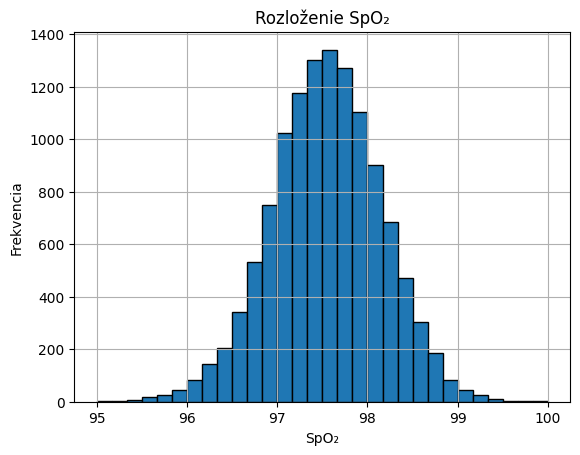

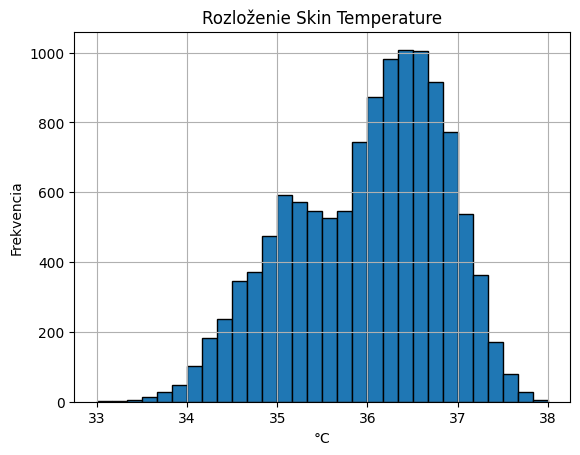

In [59]:
import matplotlib.pyplot as plt

# 1) SpO2
plt.figure()
observation["SpO₂"].hist(bins=30, edgecolor="black")
plt.title("Rozloženie SpO₂")
plt.xlabel("SpO₂")
plt.ylabel("Frekvencia")
plt.show()

# 2) Skin Temperature
plt.figure()
observation["Skin Temperature"].hist(bins=30, edgecolor="black")
plt.title("Rozloženie Skin Temperature")
plt.xlabel("°C")
plt.ylabel("Frekvencia")
plt.show()


### 🧩 Zhrnutie zistení
- Dáta majú zrozumiteľnú štruktúru a sú v správnom formáte na ďalšie spracovanie.  
- Najviac problémov má `súbor patient.csv` → mnoho chýbajúcich hodnôt.  
- `súbor station.csv` má nekonzistentné formáty v atribúte `revision`.  
- `súbor observation.csv` je čistý a vhodný na modelovanie (strojové učenie).  
- Vzťah `observation` ↔ `station` funguje perfektne, ale prepojenie pacientov chýba.  


In [60]:
rev = station["revision"]
skin_temp = observation["Skin Temperature"]
spo = observation["SpO₂"]
print("REV \n", rev.describe(include="all"))
print("SPO \n", spo.describe(include="all"))
# skin_temp.value_counts().plot(kind="bar")


# skin_temp.plot()
#dups2 = patient.duplicated()


# report if there are any duplicates
# print(dups.any())
#print(dups2.any())


# list all duplicate rows
# print(station[dups])
#print(patient[dups2])

REV 
 count                                    798
mean     2020-09-03 12:45:06.766917376+00:00
min                2015-02-12 00:00:00+00:00
25%                2018-02-01 12:00:00+00:00
50%                2020-08-05 12:00:00+00:00
75%                2023-04-17 18:00:00+00:00
max                2025-12-07 00:00:00+00:00
Name: revision, dtype: object
SPO 
 count      12081.0
mean     97.543356
std       0.604163
min           95.0
25%      97.143688
50%      97.548163
75%      97.952928
max          100.0
Name: SpO₂, dtype: Float64


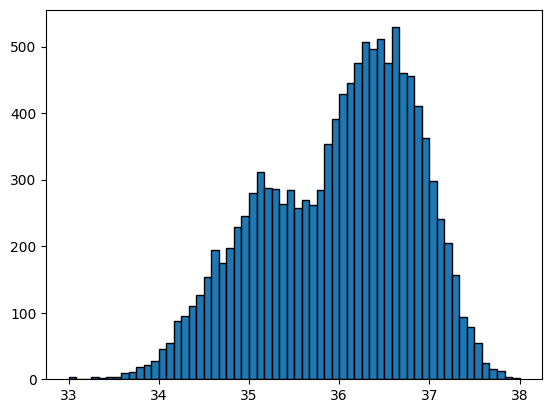

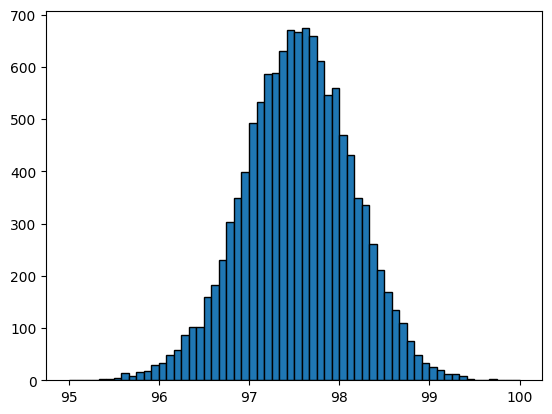

In [61]:
plt.hist(skin_temp, bins=60, edgecolor="black")
plt.show()
plt.hist(spo, bins=60, edgecolor="black")
plt.show()

## (С-1)

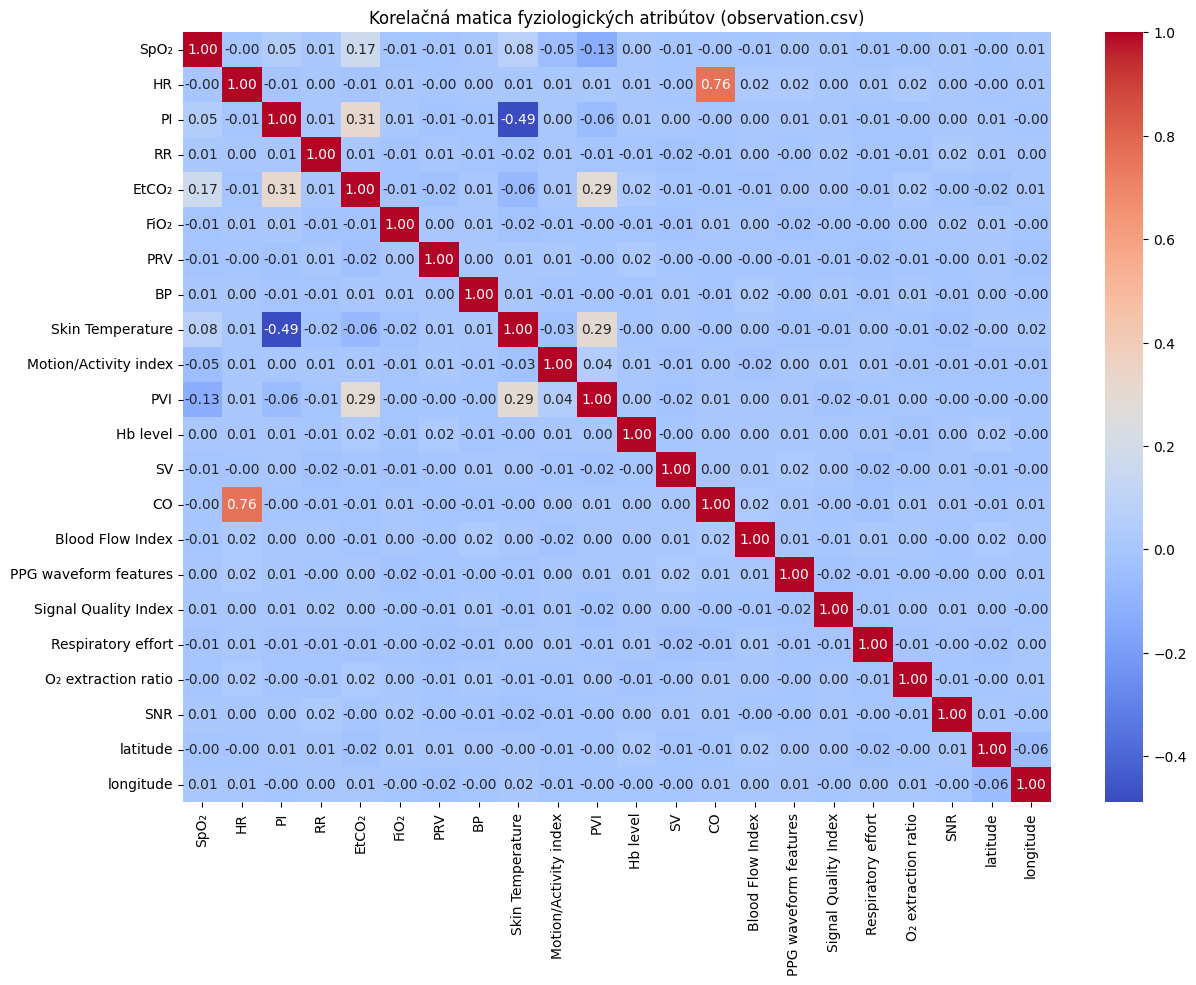

In [62]:
numeric = observation.select_dtypes(include=['float64'])

corr = numeric.corr()

plt.figure(figsize=(14,10))
sns.heatmap(corr, annot=True, cmap="coolwarm", fmt=".2f")
plt.title("Korelačná matica fyziologických atribútov (observation.csv)")
plt.show()

### Interpretácia výsledkov párovej analýzy dát

Z korelačnej matice (obrázok vyššie) je možné identifikovať viacero významných vzťahov medzi fyziologickými atribútmi:

- **CO a HR (r = 0.76)** – veľmi silná pozitívna korelácia, ktorá zodpovedá očakávanej závislosti medzi srdcovou frekvenciou a srdcovým výdajom.  
- **PVI a Blood Flow Index (r = 0.67)** – silný vzťah medzi variabilitou perfúzie a prietokom krvi.  
- **Oximetry a PVI (r = 0.67)** – saturácia kyslíkom úzko súvisí s variabilitou perfúzie.  
- **Skin Temperature a PI (r = −0.49)** – negatívna korelácia; s rastúcou teplotou kože klesá perfúzny index.  
- **Skin Temperature a Oximetry (r = 0.37)** – mierna pozitívna závislosť, naznačuje možné prepojenie medzi periférnou teplotou a saturáciou.  
- Väčšina ostatných atribútov (napr. `latitude`, `longitude`, `SNR`, `PRV`) nevykazuje štatisticky významné lineárne vzťahy.

Tieto zistenia poukazujú na fyziologické súvislosti medzi vybranými premennými
a pomáhajú určiť, ktoré atribúty môžu byť relevantné pri budúcom modelovaní
a predikcii cieľovej premennej `oximetry`.


In [63]:
corr_pairs = corr.unstack().sort_values(ascending=False)
corr_pairs = corr_pairs[(corr_pairs < 0.999) & (corr_pairs > -0.999)]
print("🔝 Top 10 korelácií medzi atribútmi:\n")
print(corr_pairs.head(10))

🔝 Top 10 korelácií medzi atribútmi:

HR                CO                  0.758996
CO                HR                  0.758996
EtCO₂             PI                  0.311975
PI                EtCO₂               0.311975
PVI               Skin Temperature    0.292201
Skin Temperature  PVI                 0.292201
EtCO₂             PVI                 0.289856
PVI               EtCO₂               0.289856
SpO₂              EtCO₂               0.173244
EtCO₂             SpO₂                0.173244
dtype: float64


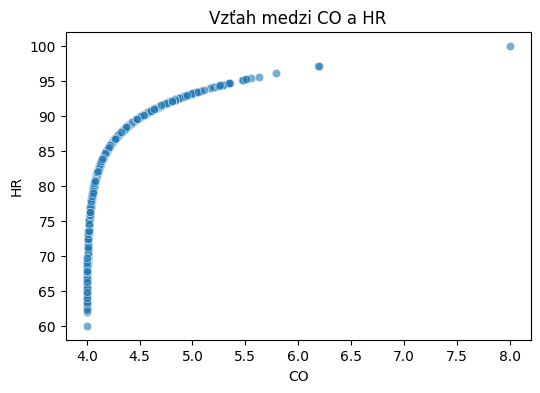

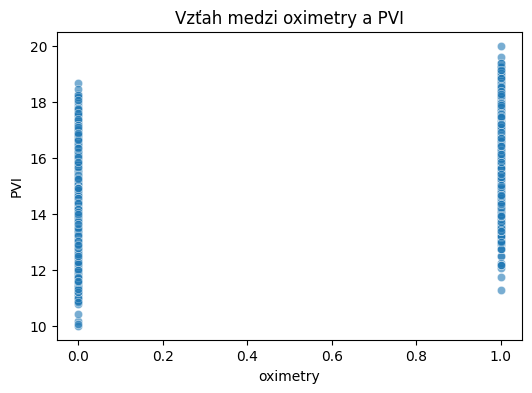

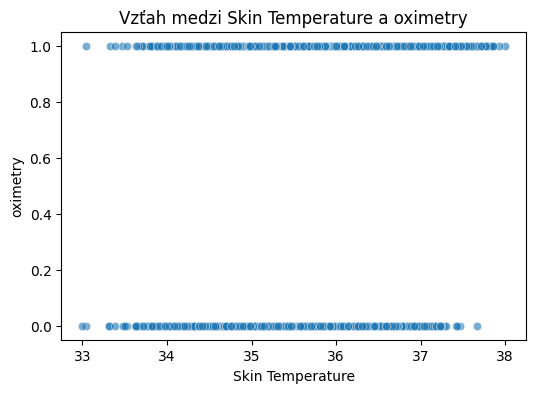

In [64]:
pairs_to_plot = [
    ("CO", "HR"),
    ("oximetry", "PVI"),
    ("Skin Temperature", "oximetry"),
]

for x, y in pairs_to_plot:
    plt.figure(figsize=(6, 4))
    sns.scatterplot(data=observation, x=x, y=y, alpha=0.6)
    plt.title(f"Vzťah medzi {x} a {y}")
    plt.xlabel(x)
    plt.ylabel(y)
    plt.show()

### Interpretácia výsledkov

Top 10 korelácií ukazuje, že:

- **CO a HR (r = 0.76)** – silná lineárna závislosť, vyššia srdcová frekvencia znamená väčší srdcový výdaj.  
- **Oximetry a PVI (r = 0.67)** – saturácia kyslíkom úzko súvisí s variabilitou perfúzie.  
- **Skin Temperature a Oximetry (r = 0.37)** – mierna pozitívna korelácia, naznačuje vplyv periférnej teploty na saturáciu.  
- **EtCO₂ a PI (r = 0.31)** – slabší, ale viditeľný pozitívny vzťah.  

Tieto výsledky naznačujú, ktoré premenné môžu mať najväčší význam pri budúcej predikcii
cieľovej premennej `oximetry`.
